Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=253010713230-6q9u8ud3l5hij7aes5btus9fnbo0tfvq.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A60250%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ftasks.readonly&state=PX5w5xYslpeAt4u5NqWjkyZNBgc3Zs&access_type=offline


/var/folders/ys/3k6qsgx53g96h9y34s_00v5h0000gn/T/ipykernel_42385/920502874.py:48: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().replace(tzinfo=timezone.utc)


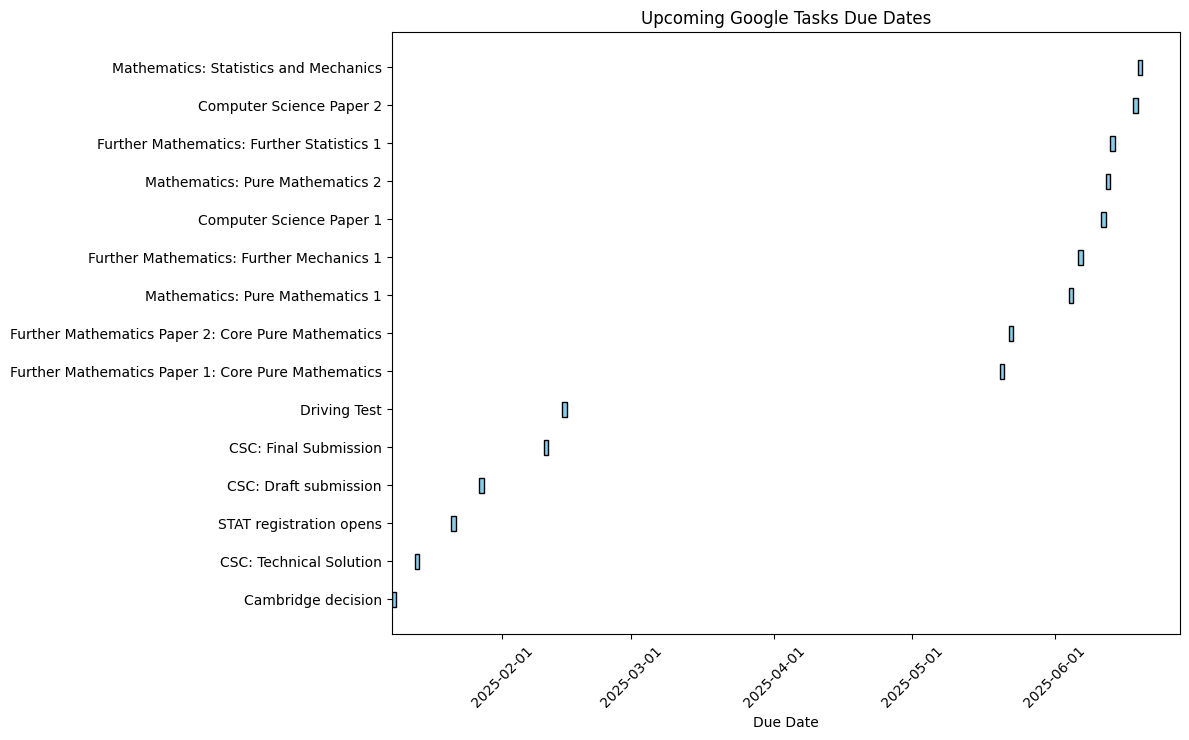

In [1]:
from __future__ import print_function
from datetime import datetime, timedelta, timezone
import os.path
import pickle
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/tasks.readonly']

def main():
    """Retrieves upcoming tasks from Google Tasks and visualizes them as a Gantt chart with bars only on due dates."""
    creds = None
    # The file token.pickle stores the user's access and refresh tokens.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If no valid credentials are available, prompt the user to log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            # Ensure you have the 'credentials.json' file in your directory.
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for future runs.
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('tasks', 'v1', credentials=creds)

    # Retrieve all task lists.
    results = service.tasklists().list(maxResults=100).execute()
    tasklists = results.get('items', [])

    if not tasklists:
        print('No task lists found.')
        return

    all_tasks = []

    now = datetime.utcnow().replace(tzinfo=timezone.utc)

    # Iterate over each task list and retrieve tasks.
    for tasklist in tasklists:
        tasks = []
        page_token = None

        # Retrieve tasks in pages until all tasks are fetched.
        while True:
            tasks_result = service.tasks().list(
                tasklist=tasklist['id'],
                maxResults=100,
                pageToken=page_token,
                showCompleted=True,
                showDeleted=False,
                showHidden=True
            ).execute()
            
            tasks.extend(tasks_result.get('items', []))
            page_token = tasks_result.get('nextPageToken')

            if not page_token:
                break

        for task in tasks:
            title = task.get('title', 'No Title')
            due = task.get('due', None)
            status = task.get('status', 'needsAction')
            if due:
                due_datetime = parse(due)
            else:
                due_datetime = None

            # Only include tasks with due dates from now onwards
            if due_datetime and due_datetime >= now:
                all_tasks.append({
                    'title': title,
                    'due': due_datetime,
                    'status': status
                })

    # Visualize the tasks as a Gantt chart with bars only on due dates.
    visualize_tasks(all_tasks)

def visualize_tasks(tasks):
    """Visualizes upcoming tasks on their due dates using matplotlib as a Gantt chart with 1-day bars."""
    # Filter tasks that have due dates.
    tasks_with_due = [task for task in tasks if task['due'] is not None]
    if not tasks_with_due:
        print('No tasks with due dates to visualize.')
        return

    # Sort tasks by due date.
    tasks_with_due.sort(key=lambda x: x['due'])

    # Limit task names to 50 characters.
    task_names = [task['title'][:50] for task in tasks_with_due]
    due_dates = [task['due'] for task in tasks_with_due]

    # Set durations to 1 day.
    durations_in_days = [1 for _ in due_dates]

    # Prepare the y positions.
    y_pos = range(len(task_names))

    # Convert dates to matplotlib format.
    due_dates_num = mdates.date2num(due_dates)

    # Create the figure and the bar plot.
    fig, ax = plt.subplots(figsize=(12, max(6, len(task_names) * 0.5)))
    ax.barh(y_pos, durations_in_days, left=due_dates_num, align='center', height=0.4, color='skyblue', edgecolor='black')

    # Set the y-axis labels.
    ax.set_yticks(y_pos)
    ax.set_yticklabels(task_names)

    # Format the x-axis with date labels.
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Set labels and title.
    plt.xlabel('Due Date')
    plt.title('Upcoming Google Tasks Due Dates')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


In [2]:
from __future__ import print_function
from datetime import datetime, timezone
import os.path
import pickle
from dateutil.parser import parse
import pandas as pd
import plotly.express as px
import numpy as np

from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# If modifying these scopes, delete the file token.pickle.
SCOPES = ["https://www.googleapis.com/auth/tasks.readonly"]


def main():
    """Retrieves tasks from now onwards from Google Tasks and visualizes them interactively."""
    creds = None
    # The file token.pickle stores the user's access and refresh tokens.
    if os.path.exists("token.pickle"):
        with open("token.pickle", "rb") as token:
            creds = pickle.load(token)
    # If no valid credentials are available, prompt the user to log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            # Ensure you have the 'credentials.json' file in your directory.
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for future runs.
        with open("token.pickle", "wb") as token:
            pickle.dump(creds, token)

    service = build("tasks", "v1", credentials=creds)

    # Retrieve all task lists.
    results = service.tasklists().list(maxResults=100).execute()
    tasklists = results.get("items", [])

    if not tasklists:
        print("No task lists found.")
        return

    all_tasks = []

    now = datetime.utcnow().replace(tzinfo=timezone.utc)

    # Iterate over each task list and retrieve tasks.
    for tasklist in tasklists:
        tasks = []
        page_token = None

        # Retrieve tasks in pages until all tasks are fetched.
        while True:
            tasks_result = (
                service.tasks()
                .list(
                    tasklist=tasklist["id"],
                    maxResults=100,
                    pageToken=page_token,
                    showCompleted=False,  # Do not include completed tasks
                    showDeleted=False,
                    showHidden=True,
                )
                .execute()
            )

            tasks.extend(tasks_result.get("items", []))
            page_token = tasks_result.get("nextPageToken")

            if not page_token:
                break

        for task in tasks:
            title = task.get("title", "No Title")
            due = task.get("due", None)
            status = task.get("status", "needsAction")  # Default to 'needsAction'
            notes = task.get("notes", "")
            updated = task.get("updated", "")
            parent = task.get("parent", "")
            position = task.get("position", "")

            if due:
                due_datetime = parse(due)
            else:
                due_datetime = None

            # Only include tasks that are not completed and have due dates from now onwards
            if status == "needsAction" and due_datetime and due_datetime >= now:
                all_tasks.append(
                    {
                        "title": title,
                        "due": due_datetime,
                        "status": status,
                        "notes": notes,
                        "updated": updated,
                        "parent": parent,
                        "position": position,
                    }
                )

    # Visualize the tasks interactively.
    visualize_tasks(all_tasks, now)

def visualize_tasks(tasks, now):
    """Visualizes tasks with due dates using Plotly for interactivity."""
    # Convert tasks to a DataFrame
    df = pd.DataFrame(tasks)

    if df.empty:
        print("No tasks with due dates to visualize.")
        return

    # Convert due dates to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df["due"]):
        df["due"] = pd.to_datetime(df["due"])

    # Sort tasks by due date
    df = df.sort_values("due")

    # Calculate days until due date
    df["days_until_due"] = (
        df["due"] - now
    ).dt.total_seconds() / 86400  # Convert seconds to days

    # int cast days until due date
    df["days_until_due"] = df["days_until_due"].astype(int)

    # Create an interactive scatter plot
    df["x"] = 1  # All points aligned vertically after axis flip

    fig = px.scatter(
        df,
        x="x",  # Align all points on x=1
        y="due",  # Use 'due' for y-axis now
        hover_name="title",
        hover_data={
            "due": False,
            "status": False,
            "notes": True,
            "updated": False,
            "parent": False,
            "position": False,
            "title": False,  # Already used in hover_name
            "days_until_due": True,
        },
        labels={"due": "Due Date", "x": ""},
        title="Upcoming Google Tasks Timeline",
        color="days_until_due",
        color_continuous_scale="RdYlGn_r",  # Reversed to have red near now
    )

    # Update marker properties to add outlines
    fig.update_traces(
        marker=dict(
            size=10,  # Adjust marker size as needed
            line=dict(width=2, color="black"),  # Width of the outline  # Outline color
        ),
        showlegend=False,  # Hide the legend
    )

    # Update layout for better visualization
    fig.update_layout(
        xaxis=dict(showticklabels=False, range=[0.7, 1.3]),  # Adjust x-axis range
        yaxis_title="Due Date",
        showlegend=False,
        hovermode="closest",
        yaxis=dict(autorange='reversed'),
        width=1000,  # Set the figure width
        height=1300,  # Set the figure height
        coloraxis_showscale=False  # Hide the color bar
    )

    # Add annotations for each data point, alternating left and right
    offset = 0.01  # Adjust the offset as needed
    for idx, row in df.iterrows():
        side = (-1) ** idx  # Alternate between 1 and -1
        x = 1  # Arrow tip position at the data point
        x_offset = x + offset * side  # Position text left or right
        xanchor = 'left' if side == 1 else 'right'
        fig.add_annotation(
            x=x,
            y=row["due"],
            ax=x_offset,
            ay=row["due"],
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            text=row["title"],
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor='black',
            xanchor=xanchor,
            align='center',
            font=dict(size=12),
        )

    # Show the figure
    fig.show()



if __name__ == "__main__":
    main()

/var/folders/ys/3k6qsgx53g96h9y34s_00v5h0000gn/T/ipykernel_42385/4105933609.py:49: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow().replace(tzinfo=timezone.utc)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed